In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2023-05-09 07:18:42.396977: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(len(physical_devices) > 0)

True


2023-05-09 07:18:45.581929: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-09 07:18:45.589185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-09 07:18:45.694402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.23GiB/s
2023-05-09 07:18:45.694446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-09 07:18:45.732536: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-09 07:18:45.732678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # 设置GPU显存自动增长模式
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 在GPU上运行一个简单的TensorFlow程序
    with tf.device('/GPU:0'):
      a = tf.ones([10000, 10000])
      b = tf.ones([10000, 10000])
      c = tf.matmul(a, b)
      print(c)
  except RuntimeError as e:
    # GPU显存不足报错
    print(e)

2023-05-09 07:18:45.893376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 07:18:45.896698: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-09 07:18:45.897965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.23GiB/s
2023-05-09 07:18:45.898036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-09 07:18:45.898089: I tensorflow/stream_executor/platf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-09 07:18:47.656391: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


tf.Tensor(
[[10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 ...
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]], shape=(10000, 10000), dtype=float32)


In [4]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [5]:
conda list tensorflow-gpu

# packages in environment at /home/kurisaw/anaconda3/envs/tensorflow-gpu:
#
# Name                    Version                   Build  Channel
tensorflow-gpu            2.4.1                h30adc30_0    defaults

Note: you may need to restart the kernel to use updated packages.


In [6]:
import sys
print(sys.version)

3.7.16 (default, Jan 17 2023, 22:20:44) 
[GCC 11.2.0]


In [7]:
# 设置 GPU 设备
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
def fire_module(x, s1x1, e1x1, e3x3):
    squeeze = Conv2D(filters=s1x1, kernel_size=1, activation='relu', padding='same')(x)
    expand1x1 = Conv2D(filters=e1x1, kernel_size=1, activation='relu', padding='same')(squeeze)
    expand3x3 = Conv2D(filters=e3x3, kernel_size=3, activation='relu', padding='same')(squeeze)
    output = Add()([expand1x1, expand3x3])
    return output

In [9]:
def fire_module(x, s1x1, e1x1, e3x3):
    squeeze = Conv2D(filters=s1x1, kernel_size=1, activation='relu', padding='same')(x)
    expand1x1 = Conv2D(filters=e1x1, kernel_size=1, activation='relu', padding='same')(squeeze)
    expand3x3 = Conv2D(filters=e3x3, kernel_size=3, activation='relu', padding='same')(squeeze)
    output = Add()([expand1x1, expand3x3])
    return output

def create_model(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = fire_module(x, s1x1=16, e1x1=64, e3x3=64)
    x = fire_module(x, s1x1=16, e1x1=64, e3x3=64)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = fire_module(x, s1x1=32, e1x1=128, e3x3=128)
    x = fire_module(x, s1x1=32, e1x1=128, e3x3=128)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = fire_module(x, s1x1=48, e1x1=192, e3x3=192)
    x = fire_module(x, s1x1=48, e1x1=192, e3x3=192)
    x = fire_module(x, s1x1=64, e1x1=256, e3x3=256)
    x = fire_module(x, s1x1=64, e1x1=256, e3x3=256)
    x = Dropout(0.5)(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 1800 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.


In [12]:
model = create_model(num_classes=2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:
# TensorBoard 回调函数
tb_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

2023-05-09 07:18:50.877194: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-09 07:18:50.877238: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-09 07:18:50.878491: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-05-09 07:18:50.884787: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-05-09 07:18:51.110526: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-09 07:18:51.110665: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [14]:
# ModelCheckpoint 回调函数
checkpoint_callback = ModelCheckpoint(
    filepath='./models/best_model.h5',
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max')

In [15]:
# EarlyStopping 回调函数
early_stop_callback = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    mode='max', 
    verbose=1,
    restore_best_weights=True)

In [16]:
optimizer = Adam(lr=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[tb_callback, checkpoint_callback, early_stop_callback])

2023-05-09 07:18:51.648660: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-09 07:18:51.669746: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


Epoch 1/50


2023-05-09 07:18:52.945197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


 2/57 [>.............................] - ETA: 7s - loss: 0.6892 - accuracy: 0.5938  

2023-05-09 07:18:55.813181: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-09 07:18:55.813210: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-09 07:18:55.903550: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-05-09 07:18:55.904701: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-05-09 07:18:55.911875: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 521 callback api events and 509 activity events. 
2023-05-09 07:18:55.931285: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-09 07:18:55.943950: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2023_05_09_07_18_55
2023-05-09 07:18:55.951051: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped t

57/57 [==============================] - 31s 488ms/step - loss: 0.6765 - accuracy: 0.6042 - val_loss: 0.7067 - val_accuracy: 0.5000
Epoch 2/50
57/57 [==============================] - 24s 427ms/step - loss: 0.2954 - accuracy: 0.8845 - val_loss: 0.6754 - val_accuracy: 0.7472
Epoch 3/50
57/57 [==============================] - 24s 424ms/step - loss: 0.2237 - accuracy: 0.9156 - val_loss: 0.7299 - val_accuracy: 0.5000
Epoch 4/50
57/57 [==============================] - 24s 424ms/step - loss: 0.1839 - accuracy: 0.9371 - val_loss: 0.5752 - val_accuracy: 0.8639
Epoch 5/50
57/57 [==============================] - 24s 420ms/step - loss: 0.1483 - accuracy: 0.9443 - val_loss: 0.7848 - val_accuracy: 0.5017
Epoch 6/50
57/57 [==============================] - 24s 420ms/step - loss: 0.1477 - accuracy: 0.9479 - val_loss: 0.4426 - val_accuracy: 0.8311
Epoch 7/50
57/57 [==============================] - 24s 422ms/step - loss: 0.1492 - accuracy: 0.9556 - val_loss: 0.3582 - val_accuracy: 0.9228
Epoch 8/50

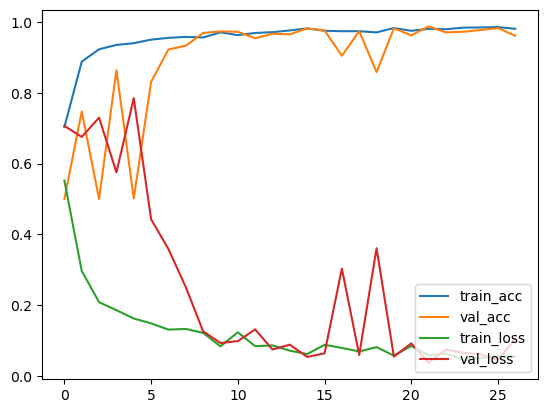

In [17]:
# 绘制训练过程中的指标变化曲线
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='lower right')
plt.show()

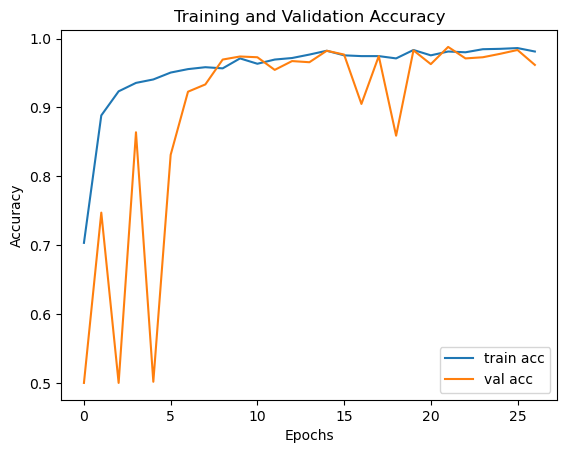

In [18]:
# 绘制训练集和验证集的准确度曲线
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

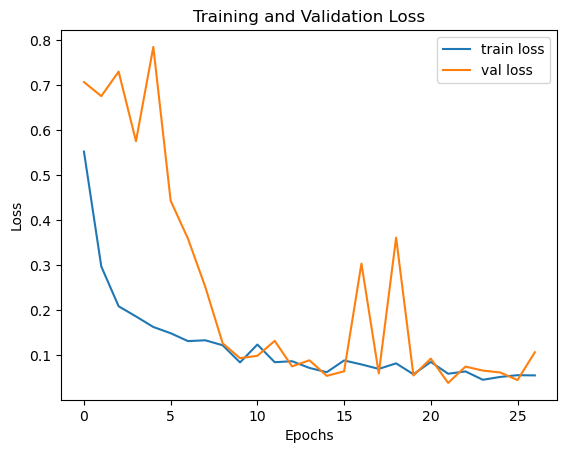

In [19]:
# 绘制训练集和验证集的loss曲线
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 200 images belonging to 2 classes.


In [21]:
loss, accuracy = model.evaluate(test_generator)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

7/7 [==============================] - 1s 87ms/step - loss: 0.2546 - accuracy: 0.9300
Test loss: 0.2545901834964752
Test accuracy: 0.9300000071525574


In [22]:
# 转换为 TensorFlow Lite 模型
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('Models/firenet_plus.tflite', 'wb') as f:
    f.write(tflite_model)

2023-05-09 07:31:15.880850: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmple2lyihi/assets


2023-05-09 07:31:17.804547: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-09 07:31:17.804626: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-05-09 07:31:17.804977: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-09 07:31:17.805197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.23GiB/s
2023-05-09 07:31:17.805223: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-09 07:31:17.805243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-09 07:31:17.805251: I tensor